<a href="https://colab.research.google.com/github/skynunu/StockPrediction_Project_bigdata/blob/main/gan_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/kanelian63/Stock-Market-Prediction-Using-GAN/blob/master/Stock%20Market%20Prediction%20on%20High-Frequency%20Data%20Using%20Generative%20Adversarial%20Nets.pdf

https://github.com/kanelian63/Stock-Market-Prediction-Using-GAN/blob/master/stock%20prediction%20with%20gan.py

https://dataplay.tistory.com/5?category=845492

In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
#%cd /content/drive/MyDrive/bigdata_term_project_2021/
%cd /content/drive/MyDrive/수업/빅데이터/과제/코드/

/content/drive/MyDrive/수업/빅데이터/과제/코드


In [204]:
import sys
from pathlib import Path
from datetime import timedelta
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.autograd as autograd
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from tqdm.notebook import trange
from contextlib2 import redirect_stdout
import random
from ipywidgets import FloatProgress
import sklearn
from sklearn.model_selection import train_test_split
import sys
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


In [205]:
#기본 hyperparameter 설정
WINDOW_GIVEN = 19
BATCH_SIZE = 64
WINDOW_SIZE = WINDOW_GIVEN + 1
EPOCHS = 60

PATH = str(WINDOW_GIVEN)+"_"+str(BATCH_SIZE)+"_"+str(EPOCHS)
GENERATOR_PATH = "model/"+ PATH +"_generator_model.pt"
DISCRIMINATOR_PATH = "model/" +PATH+"_discriminator_model.pt"

In [206]:
class Dataset(Dataset):
    def __init__(self, df, stride=1):
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(df.shape[0] - WINDOW_SIZE + 1):
          self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")

    def __len__(self):
        return self.n_idxs
    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_GIVEN
        item = {}
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])

        if i == 0  :
          item['class'] = 0
        elif self.tag_values[i][3] <= self.tag_values[i-1][3] : 
          item['class'] = 0
        else :
          item['class'] = 1  
  
        
        return item

In [207]:
def make_dataset(raw_data, scaler):
    delete_columns = ['Unnamed: 0', "Date", "Close", 'year', 'month']
    raw_data= raw_data.drop(columns =delete_columns )
    raw_data = raw_data.dropna()

    data_normal= scaler.transform(raw_data)
    data_normal_pd = pd.DataFrame(data_normal)
    DATASET_TRAIN = Dataset(data_normal)
    return DATASET_TRAIN


In [208]:
def get_result(dataset, batch_size, model):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    predict_list, answer_list, label_list = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            label = batch["class"].cuda()
            guess = model(given)

            predict_list.append(guess.cpu().numpy())
            answer_list.append(answer.cpu().numpy())
            label_list.append(label.cpu().numpy())

    return (
        np.concatenate(predict_list),
        np.concatenate(answer_list),
        np.concatenate(label_list),
    )

In [209]:
#예측한 값들을 전날 기준으로 상승 감소여부를 판단해서 클래스로 산출하는 함수
def check_class(result) :
  length = result.shape[0] 
  result = result[:,0]
  class_list = [0]
  for i in range(1,length) :
    if result[i]>result[i-1] :
      class_list.append(1)
    else :
      class_list.append(0)
  return class_list

In [210]:
def model_test_score(dataset, model, scaler) : 
  test_predict, test_answer,  test_label = get_result(dataset , BATCH_SIZE, model)
  test_scaled = scaler.inverse_transform(test_predict[:,3].reshape(-1, 1))
  predict_label = check_class(test_scaled) #예측한 값들을 전날 기준으로 상승 감소여부를 판단해서 클래스로 산출

  accuracy = np.round(accuracy_score(predict_label, test_label),3)
  f1 = np.round(f1_score(predict_label, test_label),3)
  precision = np.round(precision_score(predict_label, test_label),3)
  recall = np.round(recall_score(predict_label, test_label),3)

  return accuracy, f1, precision, recall

##1. 데이터 불러오기 & 전처리

###(1) 학습 데이터
  * 아마존 애플 넷플릭스 페이스북 구글 2000년이후 데이터 불러오기
  * 아마존 :  2014년, 2015년  /  애플 :  2017년 / 넷플릭스 :  2012년, 2017년 / 페이스북:  2017년 / 구글: 2008년 제외 
  * 제외한 년도 데이터는 테스트 데이터로 사용


  ### (2) 테스트 데이터
  * 아마존 :  2014년, 2015년 /  애플 :  2017년 , 1985년   / 넷플릭스 :  2012년, 2017년 /  구글: 2008년  / 페이스북:  2017년 
  * 데이터의 상승 하강 패턴을 고려해서 테스트 데이터셋 구성
  * 상승년도 4년 : amazon 2015년 / apple 2017년 / netflix 2017년 / facebook 2017년
  * 하강년도 4년 :  amazon 2014년 / apple 1985년 /  netflix 2012년 / google 2008년 

In [211]:
# 학습 데이터 불러오기
amazon = pd.read_csv('data/amazon_new.csv')
apple = pd.read_csv('data/apple_new.csv')
facebook = pd.read_csv('data/facebook_new.csv')
google = pd.read_csv('data/google_new.csv')
netflix = pd.read_csv('data/netflix_new.csv')

# slinding window를 할때, 년도별 잘린 구간을 구분하고자, 잘린 구간을 기점으로 데이터셋 구성
# 년도별 잘린 구간은 테스트 데이터셋으로 구성

# 아마존 2014년, 2015년 제외
amazon = amazon[amazon['year'] >=2000]
amazon_train1 = amazon[amazon['year'] <2014] 
amazon_train2 = amazon[amazon['year'] >2015] 

# 애플 2017년 제외
apple = apple[apple['year'] >=2000]
apple_train1 = apple[apple['year'] <2017] 
apple_train2 = apple[apple['year'] >2017] 

# 넷플릭스 2012년, 2017년 제외
netflix = netflix[netflix['year'] >=2000]
netflix_train1 = netflix[netflix['year'] <=2012] 
netflix_train2 = netflix[(netflix['year']  >=2012) & (netflix['year']  <=2017)] 
netflix_train3 = netflix[netflix['year'] >=2017] 

# 페이스북 2017년 제외
facebook = facebook[facebook['year'] >=2000]
facebook_train1 = facebook[facebook['year'] <=2017] 
facebook_train2 = facebook[facebook['year'] >=2017]

 #구글 2008년 제외
google = google[google['year'] >=2000]
google_train1 = google[google['year'] <=2008] 
google_train2 = google[google['year'] >=2008] 

In [212]:
# 테스트 데이터 불러오기
test_amazon_inc = pd.read_csv('data/amazon_inc.csv')
test_amazon_dec = pd.read_csv('data/amazon_dec.csv')

test_apple_inc = pd.read_csv('data/apple_inc.csv')
test_apple_dec = pd.read_csv('data/apple_dec.csv')

test_netflix_inc = pd.read_csv('data/netflix_inc.csv')
test_netflix_dec = pd.read_csv('data/netflix_dec.csv')

test_google_dec = pd.read_csv('data/google_dec.csv')
test_facebook_inc = pd.read_csv('data/facebook_inc.csv')

In [213]:
#전체 데이터 normalize 학습 
all_dataset = pd.concat([amazon,apple,netflix,facebook,google], axis = 0)
delete_columns = ['Unnamed: 0', "Date", "Close", 'year', 'month']
all_dataset_drop= all_dataset.drop(columns =delete_columns)
print("all_dataset.shape : ", all_dataset_drop.shape)
scaler = MinMaxScaler()
scaler =scaler.fit(all_dataset_drop)


all_dataset.shape :  (20573, 5)


In [214]:
#학습 dataset 만들기

# 아마존
DATASET_amazon1 = make_dataset(amazon_train1, scaler)
DATASET_amazon2 = make_dataset(amazon_train2, scaler)
DATASET_amazon = torch.utils.data.ConcatDataset([DATASET_amazon1, DATASET_amazon2])

# 애플
DATASET_apple1 = make_dataset(apple_train1, scaler)
DATASET_apple2 = make_dataset(apple_train2, scaler)
DATASET_apple = torch.utils.data.ConcatDataset([DATASET_apple1, DATASET_apple2])

# 넷플릭스
DATASET_netflix1= make_dataset(netflix_train1, scaler)
DATASET_netflix2 = make_dataset(netflix_train2, scaler)
DATASET_netflix3 = make_dataset(netflix_train3, scaler)
DATASET_netflix = torch.utils.data.ConcatDataset([DATASET_netflix1, DATASET_netflix2, DATASET_netflix3])

# 페이스북
DATASET_facebook1 = make_dataset(facebook_train1, scaler)
DATASET_facebook2 = make_dataset(facebook_train2, scaler)
DATASET_facebook = torch.utils.data.ConcatDataset([DATASET_facebook1, DATASET_facebook2])

# 구글
DATASET_google1 = make_dataset(google_train1, scaler)
DATASET_google2 = make_dataset(google_train2, scaler)
DATASET_google = torch.utils.data.ConcatDataset([DATASET_google1, DATASET_google2])

# torch dataset 만들고 dataloader 만들기
DATASET_TRAIN = torch.utils.data.ConcatDataset([DATASET_amazon, DATASET_apple, DATASET_netflix, DATASET_facebook, DATASET_google])
train_dataloader = DataLoader(DATASET_TRAIN, batch_size=BATCH_SIZE, shuffle=True, drop_last=True ) 

  0%|          | 0/3502 [00:00<?, ?it/s]

# of valid windows: 3502


  0%|          | 0/1144 [00:00<?, ?it/s]

# of valid windows: 1144


  0%|          | 0/4258 [00:00<?, ?it/s]

# of valid windows: 4258


  0%|          | 0/653 [00:00<?, ?it/s]

# of valid windows: 653


  0%|          | 0/3250 [00:00<?, ?it/s]

# of valid windows: 3250


  0%|          | 0/986 [00:00<?, ?it/s]

# of valid windows: 986


  0%|          | 0/892 [00:00<?, ?it/s]

# of valid windows: 892


  0%|          | 0/1144 [00:00<?, ?it/s]

# of valid windows: 1144


  0%|          | 0/643 [00:00<?, ?it/s]

# of valid windows: 643


  0%|          | 0/1991 [00:00<?, ?it/s]

# of valid windows: 1991


  0%|          | 0/2402 [00:00<?, ?it/s]

# of valid windows: 2402


In [215]:
#테스트 dataset 만들기

#증가 테스트 데이터셋
DATASET_inc1 = make_dataset(test_amazon_inc, scaler)
DATASET_inc2 = make_dataset(test_apple_inc, scaler)
DATASET_inc3 = make_dataset(test_netflix_inc, scaler)
DATASET_inc4 = make_dataset(test_facebook_inc, scaler)
DATASET_TEST_INC = torch.utils.data.ConcatDataset([DATASET_inc1, DATASET_inc2,DATASET_inc3,DATASET_inc4])

#감소 테스트 데이터셋
DATASET_dec1 = make_dataset(test_amazon_dec, scaler)
DATASET_dec2 = make_dataset(test_apple_dec, scaler)
DATASET_dec3 = make_dataset(test_netflix_dec, scaler)
DATASET_dec4 = make_dataset(test_google_dec, scaler)
DATASET_TEST_DEC = torch.utils.data.ConcatDataset([DATASET_dec1, DATASET_dec2,DATASET_dec3,DATASET_dec4])

  0%|          | 0/233 [00:00<?, ?it/s]

# of valid windows: 233


  0%|          | 0/232 [00:00<?, ?it/s]

# of valid windows: 232


  0%|          | 0/232 [00:00<?, ?it/s]

# of valid windows: 232


  0%|          | 0/232 [00:00<?, ?it/s]

# of valid windows: 232


  0%|          | 0/233 [00:00<?, ?it/s]

# of valid windows: 233


  0%|          | 0/233 [00:00<?, ?it/s]

# of valid windows: 233


  0%|          | 0/231 [00:00<?, ?it/s]

# of valid windows: 231


  0%|          | 0/234 [00:00<?, ?it/s]

# of valid windows: 234


## 2. GAN : generator, discriminator 구현
###  - 논문 참조 : Stock Market Prediction on High-Frequency Data Using Generative Adversarial Nets

In [216]:
"""
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.
The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria.
This function is applied to the models immediately after initialization.
"""
# 논문에 초기 가중치를 어떻게 하라는 구체적인 설명이 없어서 DCGAN의 초기 가중치를 가져옴
# custom weights initialization called on netG and netD from Normal distribution
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [217]:
# Generator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
       
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        out = self.fc(out[:, -1,:])
        return x[:,0,:]+out #skip connection



In [218]:
input_dim = 5
hidden_dim = 100
num_layers = 3
output_dim = 5

# generator 만들기
generator = Generator(input_dim, hidden_dim, num_layers, output_dim)
generator.cuda()


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
generator.apply(weights_init)
print(generator)

Generator(
  (lstm): LSTM(5, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)


In [219]:
# Descriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,dim_features =32):
        super(Discriminator, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        self.conv1d_1 = nn.Conv1d(in_channels=5, out_channels=dim_features, kernel_size=3, stride=1)
        self.bn_1 = nn.BatchNorm1d(dim_features)
        self.relu_1 = nn.ReLU()
        
        self.conv1d_2 = nn.Conv1d(in_channels=dim_features, out_channels=dim_features*2, kernel_size=3, stride=1)
        self.bn_2 = nn.BatchNorm1d(dim_features*2)
        self.relu_2 = nn.ReLU()

        self.conv1d_3 = nn.Conv1d(in_channels=dim_features*2, out_channels=dim_features*4, kernel_size=3, stride=1)
        self.bn_3 = nn.BatchNorm1d(dim_features*4)
        self.relu_3 = nn.ReLU()

        self.linear_1 = nn.Linear(1792, dim_features*6)
        self.leaky_1 = nn.LeakyReLU()
        self.linear_2 = nn.Linear(dim_features*6, 1)

        self.ac_1 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1d_1(x)
        x = self.bn_1(x)
        x = self.relu_1(x)

        x = self.conv1d_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)

        x = self.conv1d_3(x)
        x = self.bn_3(x)
        x = self.relu_3(x)

        x = x.view(x.shape[0], -1)
        
        x = self.linear_1(x)
        x = self.leaky_1(x)
        x = self.linear_2(x)
        
        x = self.ac_1(x)
        
        return x

In [220]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
in_channels = 1
out_channels = 5
kernel_size = 20

# Discriminator 만들기
discriminator = Discriminator(in_channels, out_channels, kernel_size).cuda()
discriminator.apply(weights_init)

#  Discriminator 모델 출력
print(discriminator)


Discriminator(
  (conv1d_1): Conv1d(5, 32, kernel_size=(3,), stride=(1,))
  (bn_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (conv1d_2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU()
  (conv1d_3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (bn_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU()
  (linear_1): Linear(in_features=1792, out_features=192, bias=True)
  (leaky_1): LeakyReLU(negative_slope=0.01)
  (linear_2): Linear(in_features=192, out_features=1, bias=True)
  (ac_1): Sigmoid()
)


## 3. 주식 예측을 위한 GAN 모델 학습
  * GAN 모델 하이퍼 파라미터 설정
  * GAN 모델 학습
  * GAN 모델 generator, discriminator loss 그래프 그리기

In [221]:
# GAN 모델 하이퍼 파라미터 설정

# Initialize BCELoss function
adversarial_loss  = nn.BCELoss()

# Establish convention for real and fake labels during training
lr = 0.001
beta1 = 0.9

# Setup Adam optimizers for both G and D
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))


discriminator.cuda()
adversarial_loss.cuda()

G_losses = []
D_losses = []
D_losses_sum = []
G_data = []

lamda_adv = 0.01
lamda_p = 20
lamda_dpl = 0.8

fake_label = torch.zeros(BATCH_SIZE,1, dtype=torch.float).cuda()
real_label = torch.ones(BATCH_SIZE,1, dtype=torch.float).cuda()

In [222]:

for epoch in range(EPOCHS):
    for batch in train_dataloader:
        x_train = batch["given"].cuda()
        y_train = batch["answer"].cuda()
  
      # train G
        # gradient 0
        generator.zero_grad()
        
        # product fake_data for d
        generated_data = generator(x_train).reshape(BATCH_SIZE,1,5)
        fake_data = torch.cat((x_train, generated_data), axis=1)
        fake_data = fake_data.reshape(BATCH_SIZE, 5 ,WINDOW_SIZE)

        # train d with fake_data
        output_fake_d = discriminator(fake_data)
        
        loss_g_adv = adversarial_loss(output_fake_d, real_label)
        
        L_p = torch.norm(generated_data.reshape(BATCH_SIZE,5) - y_train)
                
        L_dpl = (torch.sign(generated_data - x_train.reshape(BATCH_SIZE,WINDOW_GIVEN,5)[0][-1])- torch.sign(y_train - x_train.reshape(BATCH_SIZE,WINDOW_GIVEN,5)[0][-1])).mean().abs()
        
        # Loss G
        loss_g = lamda_adv*loss_g_adv + lamda_p*L_p + lamda_dpl*L_dpl
        
        loss_g.backward()
        
        loss_g_average = loss_g.mean().item()
    
        # update weight
        optimizer_g.step()
        
        
    # train D
        # gradient 0
        discriminator.zero_grad()

        # train d with real data
        real_data = torch.cat((x_train, y_train.reshape(BATCH_SIZE,1,5)),axis=1).reshape(BATCH_SIZE,5,WINDOW_SIZE)

        output_real_d = discriminator(real_data)

        # Loss D with real_data
        # save gradient d with real_data
        loss_real_d = adversarial_loss(output_real_d, real_label)

        loss_real_d.backward()

        
        # train d with fake data
        # product real fake_data
        generated_data = generator(x_train).reshape(BATCH_SIZE,1,5)
        fake_data = torch.cat((x_train, generated_data),axis=1).reshape(BATCH_SIZE,5,WINDOW_SIZE)
        
        # Loss D with fake_data
        output_fake_d = discriminator(fake_data)
        loss_fake_d = adversarial_loss(output_fake_d, fake_label)
        
        # save gradient d with fake_data
        loss_fake_d.backward()
        
        loss_fake_d_average = loss_fake_d.mean().item()
        
        # sum of Loss D
        loss_sum = loss_real_d + loss_fake_d
        
        loss_d_sum = loss_sum.mean().item()
        
        # gradient update
        optimizer_d.step()
        
        # Output training stats
       

    # Save Losses for plotting later
    D_losses.append(loss_fake_d_average)
    G_losses.append(loss_g_average) 
    print('%d번째 학습 =>  discriminator loss : %f, genrator loss : %f' % (epoch+1, loss_fake_d_average, loss_g))


#generator, discriminator 저장
torch.save(generator.state_dict(), GENERATOR_PATH)
torch.save(discriminator.state_dict(), DISCRIMINATOR_PATH)

with open(GENERATOR_PATH, "wb") as f:
    torch.save(generator.state_dict(),f)

with open(DISCRIMINATOR_PATH, "wb") as f:
    torch.save(generator.state_dict(),f)


D_losses = pd.DataFrame(D_losses)
G_losses = pd.DataFrame(G_losses)


1번째 학습 =>  discriminator loss : 0.684497, genrator loss : 5.236153
2번째 학습 =>  discriminator loss : 0.649711, genrator loss : 5.189653
3번째 학습 =>  discriminator loss : 0.477375, genrator loss : 7.929291
4번째 학습 =>  discriminator loss : 0.377174, genrator loss : 5.722734
5번째 학습 =>  discriminator loss : 0.371206, genrator loss : 3.639832
6번째 학습 =>  discriminator loss : 0.170470, genrator loss : 4.766150
7번째 학습 =>  discriminator loss : 0.236941, genrator loss : 3.741702
8번째 학습 =>  discriminator loss : 0.421506, genrator loss : 3.759188
9번째 학습 =>  discriminator loss : 0.262543, genrator loss : 4.139966
10번째 학습 =>  discriminator loss : 0.319088, genrator loss : 4.145564
11번째 학습 =>  discriminator loss : 0.145384, genrator loss : 6.900580
12번째 학습 =>  discriminator loss : 0.362909, genrator loss : 2.478645
13번째 학습 =>  discriminator loss : 0.508421, genrator loss : 3.392833
14번째 학습 =>  discriminator loss : 0.023527, genrator loss : 5.159268
15번째 학습 =>  discriminator loss : 0.154895, genrator loss 

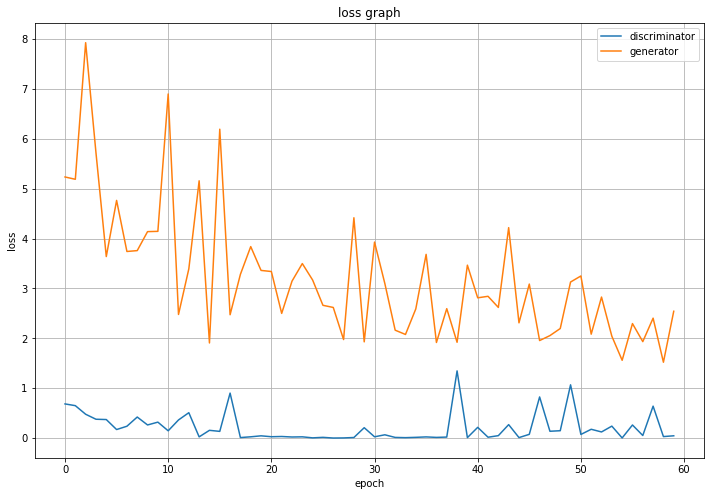

In [223]:
# GAN 모델 generator, discriminator loss 그래프 그리기
%matplotlib inline 
x_axis =np.arange(1,EPOCHS+1)
plt.figure(figsize=(12,8))
plt.plot(D_losses) # line1 plot(x레이블, y레이블)
plt.plot(G_losses) # line2 plot(x레이블, y레이블)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss graph')
plt.legend(['discriminator', 'generator']) #plt.legend([라인1범례, 라인2범례])
plt.grid(True) #격자 표시 여부

fig = plt.gcf()
fig.savefig("image/"+PATH+"_train_loss.png")
plt.show()


## 4. 모델 테스트 하기
### - 증가 패턴 데이터셋과 감소 패턴 데이터셋 결과 비교
### - 증가 패턴 데이터셋 : amazon 2015년 / apple 2017년 / netflix 2017년 / facebook 2017년
### - 감소 패턴 데이터셋 :  amazon 2014년 / apple 1985년 /  netflix 2012년 / google 2008년 
### - 실험순서
  
  * 테스트 데이터셋에 대하여, generated data 만들기
  
  * 수정종가 예측값과 수정종가 정답값에 대하여 inverse_normalize 적용
  
  * 수정종가에 대해서 예측한 값 그래프 나타내기 실험

  * 전날 기준으로 증가 감소에 대한 클래스 예측값 산출해서 실제 증감여부와 비교해서 정확도 산출
 

In [224]:
#모델 불러오기
# Model Load
with open(GENERATOR_PATH, "rb") as f:
    SAVED_MODEL = torch.load(f)

TEST_GENERATOR_PATH = "model/"+PATH+"_generator_model.pt"

test_generator = Generator(input_dim, hidden_dim, num_layers, output_dim)
test_generator.load_state_dict(torch.load(TEST_GENERATOR_PATH))
test_generator.to(torch.device("cuda")) # use GPU 
test_generator.eval()

Generator(
  (lstm): LSTM(5, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)

In [225]:
#수정종가에 대하여 MinMaxScaler 학습
test_scaler = MinMaxScaler()
all_dataset_adjclose = all_dataset_drop['Adj Close'].to_numpy()
test_scaler.fit(all_dataset_adjclose.reshape(-1, 1))

MinMaxScaler()

### 4-1. 증가 패턴 데이터셋 테스트


In [226]:
# 테스트 데이터셋에 대하여, generated data 만들기
# generated data가 test_predict
# test answer는  test_predict기 예측하는 시점에서의 정답값
# test_label는 전날 기준으로 상승(1) 하강(0) 여부를 나타내는 클래스
test_predict_inc, test_answer_inc,  test_label_inc = get_result(DATASET_TEST_INC , BATCH_SIZE, test_generator)
pred_scaled = test_scaler.inverse_transform(test_predict_inc[:,3].reshape(-1, 1))
ans_scaled = test_scaler.inverse_transform(test_answer_inc[:,3].reshape(-1, 1))

print(pred_scaled.shape)
print(ans_scaled.shape)

(929, 1)
(929, 1)


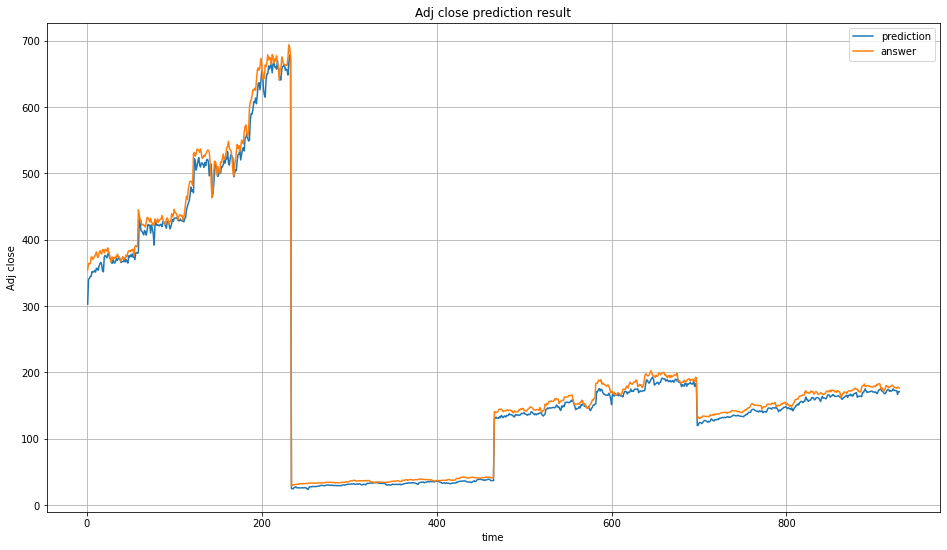

In [227]:
# 증가패턴 수정종가 예측값 그래프 
%matplotlib inline 
x_axis =np.arange(1,pred_scaled.shape[0]+1)
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(x_axis,pred_scaled) # line1 plot(x레이블, y레이블)
plt.plot(x_axis,ans_scaled) # line2 plot(x레이블, y레이블)
plt.xlabel('time')
plt.ylabel('Adj close')
plt.title('Adj close prediction result')
plt.legend(['prediction', 'answer']) #plt.legend([라인1범례, 라인2범례])
plt.grid(True) #격자 표시 여부

fig = plt.gcf()
fig.savefig("image/" +PATH+"_increase pattern.png")
plt.show()


In [228]:
#전날 기준 증가 감소여부 예측 정확도 평가
predict_label_inc = check_class(pred_scaled)
accuracy, f1, precision, recall  = model_test_score(DATASET_TEST_INC, test_generator, test_scaler)

print("=================GAN모델 예측 결과==================")
print("증가 패턴 수정 종가에 대한 증가 감소 예측 정확도 평가")
print("(1) accuracy score = ",  accuracy)
print("(2) recall score = ",  recall)
print("(3) precision score = ", precision)
print("(4) f1 score = ",  f1 )

=================GAN모델 예측 결과==================
증가 패턴 수정 종가에 대한 증가 감소 예측 정확도 평가
(1) accuracy score =  0.703
(2) recall score =  0.734
(3) precision score =  0.705
(4) f1 score =  0.719


### 4-2. 감소 패턴 데이터셋 테스트


In [229]:
# 테스트 데이터셋에 대하여, generated data 만들기
# generated data가 test_predict
# test answer는  test_predict기 예측하는 시점에서의 정답값
# test_label는 전날 기준으로 상승(1) 하강(0) 여부를 나타내는 클래스
test_predict_dec, test_answer_dec,  test_label_dec = get_result(DATASET_TEST_DEC , BATCH_SIZE, test_generator)

#예측값과 정답값에서 수정종가에 대하여 inverse_normalize 적용
pred_scaled_dec = test_scaler.inverse_transform(test_predict_dec[:,3].reshape(-1, 1))
ans_scaled_dec = test_scaler.inverse_transform(test_answer_dec[:,3].reshape(-1, 1))

print(pred_scaled_dec.shape)
print(ans_scaled_dec.shape)

(931, 1)
(931, 1)


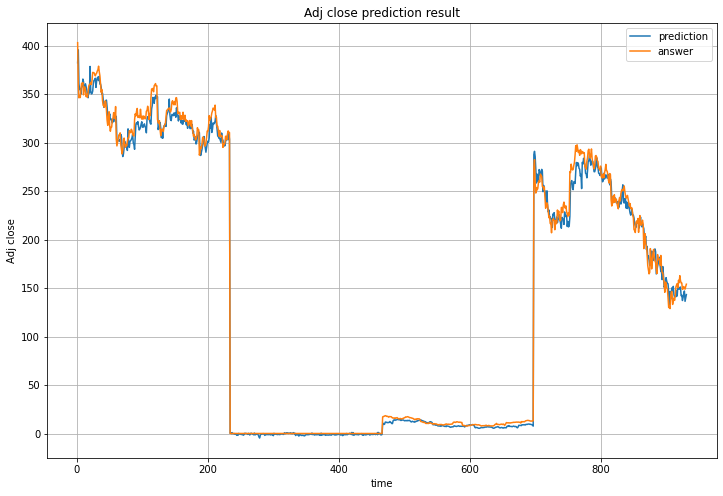

In [230]:
# 감소 패턴 수정종가 예측값 그래프 
%matplotlib inline 
x_axis =np.arange(1,pred_scaled_dec.shape[0]+1)
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(x_axis,pred_scaled_dec) # line1 plot(x레이블, y레이블)
plt.plot(x_axis,ans_scaled_dec) # line2 plot(x레이블, y레이블)
plt.xlabel('time')
plt.ylabel('Adj close')
plt.title('Adj close prediction result')
plt.legend(['prediction', 'answer']) #plt.legend([라인1범례, 라인2범례])
plt.grid(True) #격자 표시 여부
fig = plt.gcf()
fig.savefig("image/"+PATH+ "_decrease pattern.png")
plt.show()


In [231]:
#전날 기준 증가 감소여부 예측 정확도 평가

predict_label_dec = check_class(pred_scaled_dec)
accuracy, f1, precision, recall  = model_test_score(DATASET_TEST_DEC, test_generator, test_scaler)

print("=================GAN모델 예측 결과===================")
print("감소패턴 수정 종가에 대한 증가 감소 예측 정확도 평가")
print("(1) accuracy score = ",  accuracy)
print("(2) recall score = ",  recall)
print("(3) precision score = ", precision)
print("(4) f1 score = ",  f1 )


=================GAN모델 예측 결과===================
감소패턴 수정 종가에 대한 증가 감소 예측 정확도 평가
(1) accuracy score =  0.712
(2) recall score =  0.678
(3) precision score =  0.716
(4) f1 score =  0.696


## 5. GAN모델 + XGBoost clssifier
### - 학습이 완료된 GAN모델에 학습 데이터를 넣고, 데이터를 생성해서, XGBoost classifier에 학습 시킨다.
### - GAN모델에서 생성된 데이터를 XGBoost Classifier에 넣고 증감여부를 y값으로 줘서 학습을 시킨 후 테스트해보기
### - 4개의 측정지표 중에서  GAN 단일모델보다 precision 지표가 더 좋게 나온다.



In [232]:
#GAN에서 생성된 데이터를 XGBClassifier로 학습시킨다. 
train_predict, train_answer, train_label = get_result(DATASET_TRAIN, BATCH_SIZE, test_generator)
train_predict.shape

train_x, train_y = train_predict, train_label
xgb_model = XGBClassifier(n_estimators =400, learning_rate = 0.1 , max_depth=4 )
xgb_model.fit(train_x, train_y)


XGBClassifier(max_depth=4, n_estimators=400)

In [233]:
xgb_result = xgb_model.predict(test_predict_inc)

from sklearn.metrics import accuracy_score

accuracy = np.round(accuracy_score(xgb_result , test_label_inc),3)
recall = np.round(recall_score(xgb_result,test_label_inc),3)
precision = np.round(precision_score(xgb_result ,test_label_inc),3)
f1 = np.round(f1_score(xgb_result ,test_label_inc),3)

print("=================GAN모델+xgboost=====================")
print("증가 패턴 수정 종가에 대한 증가 감소 예측 정확도 평가")
print("(1) accuracy score = ",  accuracy)
print("(2) recall score = ",  recall)
print("(3) precision score = ", precision)
print("(4) f1 score = ",  f1 )

=================GAN모델+xgboost=====================
증가 패턴 수정 종가에 대한 증가 감소 예측 정확도 평가
(1) accuracy score =  0.571
(2) recall score =  0.594
(3) precision score =  0.641
(4) f1 score =  0.617


In [234]:
xgb_result = xgb_model.predict(test_predict_dec)

from sklearn.metrics import accuracy_score

accuracy = np.round(accuracy_score(xgb_result , test_label_dec),3)
recall = np.round(recall_score(xgb_result,test_label_dec),3)
precision = np.round(precision_score(xgb_result ,test_label_dec),3)
f1 = np.round(f1_score(xgb_result ,test_label_dec),3)

print("==================GAN모델+xgboost=====================")
print("감소 패턴 수정 종가에 대한 증가 감소 예측 정확도 평가")
print("(1) accuracy score = ",  accuracy)
print("(2) recall score = ",  recall)
print("(3) precision score = ", precision)
print("(4) f1 score = ",  f1 )

==================GAN모델+xgboost=====================
감소 패턴 수정 종가에 대한 증가 감소 예측 정확도 평가
(1) accuracy score =  0.615
(2) recall score =  0.565
(3) precision score =  0.716
(4) f1 score =  0.632
